In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import pandas as pd
import pymc3 as pm
import arviz as az
import corner
import astropy.units as u

import theano
import theano.tensor as tt
from theano.compile.ops import as_op

from numba import njit

# import seaborn as sns; sns.set(font_scale=1.5)
plt.style.use(['science', 'notebook', 'grid'])

In [9]:
x_data = np.linspace(-100, 100, 500)
bandwidth = np.arange(450, 750, 5)
# bandwidth = np.arange(450, 750)

In [10]:
bandwidth

array([450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510,
       515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575,
       580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640,
       645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705,
       710, 715, 720, 725, 730, 735, 740, 745])

In [44]:
def fresnel_polikromatik(x, x0, d):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y0 += y
    return y0 / (2 * np.mean(y0))

In [45]:
d_moon = 374348.01497938664 # satuan km
x0 = 0.
# A = 96452.

In [46]:
y_data = fresnel_polikromatik(x_data, x0, d_moon)
# y_data = fresnel_Dif(x_data, x0, d_moon, A)

Text(0, 0.5, 'Intensity')

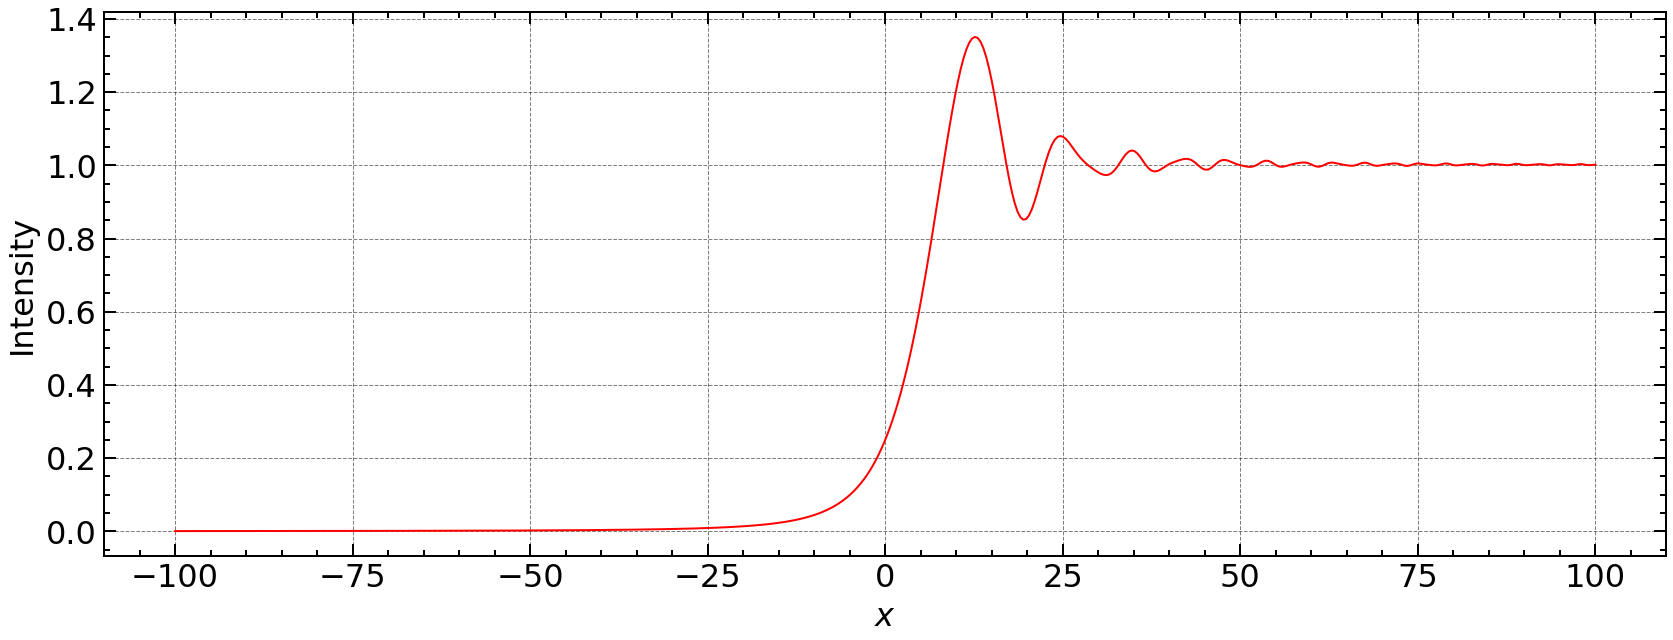

In [47]:
plt.figure(figsize = (14,5), facecolor='w')
plt.plot(x_data, y_data, 'r-', lw=1)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

## Kurva Transmisi

In [ ]:
df = pd.read_csv('Bessel_R-1.txt', delimiter='\t', header=None)
df.head()

In [ ]:
data = df[[0, 2]]
data.columns = ['wavelength','percentage']

In [ ]:
data = data.dropna(axis=0)

In [ ]:
data['percentage']

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
data_clean = data.dropna(axis=1)

In [ ]:
data_clean

In [ ]:
data['wavelength'] = data_clean['wavelength'].astype('float')
data['transmissivity'] = data_clean['percentage']/100.
data.head()

In [ ]:
x = data['wavelength']
# x = data['wavelength'] * 1e-9 # ubah ke meter
y = data['transmissivity']
plt.plot(x, y, 'g')

In [ ]:
x.shape

In [ ]:
f = interp1d(x, y, kind='cubic')

In [ ]:
x_dense = np.linspace(500, 900, 100)
y_dense = f(x_dense)

In [ ]:
plt.plot(x_dense, y_dense, 'r', label='R band')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmissivity [%]')
plt.legend()

In [ ]:
bandwidth

In [ ]:
ytest = f(bandwidth[6])
ytest

In [ ]:
def fresnel_polikromatik2(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f(bandwidth[i]) * y
        y0 += y_new
    return y0

In [ ]:
y_data2 = fresnel_polikromatik2(x_data, x0, d_moon, A)

In [ ]:
plt.figure(figsize = (14,5), facecolor='w')
plt.plot(x_data, y_data2, 'r-', lw=1)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

## Blackbody Curve

In [ ]:
from astropy.modeling.models import BlackBody

In [ ]:
temperature = 5800 * u.K
xaxis = np.arange(200, 2500) * u.nm
xaxis2 = np.arange(2000, 25000) * u.AA
pita = bandwidth * u.nm

In [ ]:
bb = BlackBody(temperature=temperature)
denum = np.max(bb(xaxis))
# denum = np.max(bb(bandwidth.value))
# bb_results = bb(bandwidth.value) / denum # normalize
bb_results = bb(xaxis) / denum

In [ ]:
plt.plot(xaxis, bb_results, 'b-')

In [ ]:
bb.lambda_max().value

In [ ]:
denum.decompose()

In [ ]:
bb(xaxis).decompose()

In [ ]:
def fresnel_polikromatik3(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f(bandwidth[i]) * (bb(pita[i]).decompose().value / denum.decompose().value) * y
        # y_new = f(bandwidth[i]) * y
        y0 += y_new
    return y0

In [ ]:
y_data3 = fresnel_polikromatik3(x_data, x0, d_moon, A)

In [ ]:
plt.figure(figsize = (14,5), facecolor='w')
plt.plot(x_data, y_data3, 'r-', lw=1)
# plt.plot(x_data, y_data2, 'b-', lw=1)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

In [ ]:
@as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dvector])
def t_fresnel_polikromatik3(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        # y_new = f(bandwidth[i]) * (bb(pita[i]).decompose().value / denum.decompose().value) * y
        y_new = f(bandwidth[i]) * y
        y0 += y_new
    return y0

In [ ]:
x_shared = theano.shared(x_data)
d_shared = theano.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1000, sigma=500)
    σ = pm.HalfCauchy('σ', beta=20)
    x0 = pm.Normal('x0', mu=0., sigma=10.)
    
    μ = t_fresnel_polikromatik3(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_data)
    
pm.model_to_graphviz(model_polikromatik)

In [ ]:
with model_polikromatik:
    trace = pm.sample(3000, tune=2000, return_inferencedata=True, cores=1)

## *Blackbody Curve* II

In [ ]:
from astropy.constants import h, k_B, c

In [ ]:
k_B

In [ ]:
def wien(T):
    return 0.2898/T

In [ ]:
wien(5800)

In [ ]:
def planck2(λ, T):
    a = 3.7412e-5 / λ**5
    b = np.exp(1.43879/(λ*T)) - 1
    return a/b

# def planck3(λ, T):
#     a = 1.191043e-61 / λ**5
#     b = (np.exp(1.4387769e-11/(λ*T)) - 1)
#     return a/b

In [ ]:
wave = np.arange(200, 2500)*u.nm
wave2 = wave.to(u.cm)
wave2

In [ ]:
result = planck2(wave2.value, 5800)
result

In [ ]:
# den = np.max(result)
result_fin = (result - np.min(result))/(np.max(result) - np.min(result))

plt.plot(wave, result_fin)

In [ ]:
bandwidth2 = bandwidth*u.nm.to(u.cm)
bandwidth2

In [ ]:
result2 = planck2(bandwidth2, 5800)

In [ ]:
result_fin2 = (result2 - np.min(result))/(np.max(result) - np.min(result))

plt.plot(wave, result_fin, 'k-')
plt.plot(bandwidth, result_fin2, 'r-')

# plt.plot(wave, result, 'k-')
# plt.plot(bandwidth, result2, 'r-')

In [ ]:
def fresnel_polikromatik4(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        # y_new = f(bandwidth[i]) * planck2(bandwidth2[i], 5800) * y
        y_new = f(bandwidth[i]) * planck2(bandwidth2[i], 5800)/den * y
        # y_new = f(bandwidth[i]) * y
        y0 += y_new
    return y0

In [ ]:
σ_true = 500.

y_data4 = fresnel_polikromatik4(x_data, x0, d_moon, A)
y_data4 = np.random.normal(y_data4, scale=σ_true)

In [ ]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data, y_data4, s=5, c='r', alpha=0.7)
# plt.plot(x_data, y_data4, 'r-', lw=1)
# plt.plot(x_data, y_data_mono, 'b-', lw=1)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

In [ ]:
@as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dvector])
def t_fresnel_polikromatik4(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth2)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f(bandwidth[i]) * planck2(bandwidth2[i], 5800)/den * y
        # y_new = f(bandwidth[i]) * y
        y0 += y_new
    return y0

In [ ]:
x_shared = theano.shared(x_data)
d_shared = theano.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=900, sigma=500)
    σ = pm.HalfCauchy('σ', beta=20)
    x0 = pm.Normal('x0', mu=0., sigma=10.)
    
    μ = t_fresnel_polikromatik4(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_data4)
    
pm.model_to_graphviz(model_polikromatik)

In [ ]:
with model_polikromatik:
    trace = pm.sample(3000, tune=2000, return_inferencedata=True, cores=1)

In [ ]:
az.plot_trace(trace)

In [ ]:
az.summary(trace)

In [ ]:
chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik)

In [ ]:
crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # 2.5% persentil 
crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # 97.5% persentil
mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, y_data4, c='r', s=10, alpha=0.3)
# plt.plot(x_data2, y_data2, 'r-', lw=1, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')